In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/classification short video")

Mounted at /content/drive


### 1. Import module

In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import io
import torch.nn as nn
import os
import pandas as pd
import cv2
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torchvision import transforms
import gc

### Load the dataset

#### function load video

In [8]:
def load_video(path, max_frame=100, size=(480,480)):
    capture = cv2.VideoCapture(path)
    all_frames = []
    while True:
        ret, frame = capture.read()
        if len(all_frames) == max_frame:
            break
        if not ret:
            break
        frame = get_center_square(frame)
        frame = cv2.resize(frame,size)
        frame = frame[:, :, [2,1,0]] # ảnh đọc ra bởi cv2 ở dạng BGR, chuyển về RGB
        frame = torch.tensor(frame)
        frame = frame.permute(2,0,1) # chuyển về channel, height, width
        all_frames.append(frame)
    capture.release()
    return torch.stack(all_frames, dim=0) # dim = (100, 3, size[0], size[1])


"""Get center square of frame"""
def get_center_square(frame):
    y, x = frame.shape[0:2]
    min_lenght = min(x,y)
    start_x = (x//2) - min_lenght//2
    start_y = (y//2) - min_lenght//2
    frame = frame[start_y : start_y + min_lenght, start_x : start_x + min_lenght]
    return frame

#### Create dataframe

In [6]:
def create_dataframe_metadata(df, start, end, label_encoder=None, encode_label=None):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[start:end], df_playCello[start:end], df_CricketShot[start:end], df_ShavingBeard[start:end], df_TennisSwing[start:end]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    if label_encoder is not None:
        new_df['tag'] = label_encoder.fit_transform(new_df['tag'])
    else:
        new_df['tag'] = new_df['tag'].map(encode_label)
    return new_df

In [7]:
folder_path_train = "./video_data/train/"
folder_path_test = "./video_data/test/"

train_df = pd.read_csv("./video_data/train.csv")
test_df = pd.read_csv("./video_data/test.csv")

In [9]:
print(train_df['tag'].value_counts())
print(test_df['tag'].value_counts())

tag
Punch           121
PlayingCello    120
CricketShot     118
ShavingBeard    118
TennisSwing     117
Name: count, dtype: int64
tag
CricketShot     49
TennisSwing     49
PlayingCello    44
ShavingBeard    43
Punch           39
Name: count, dtype: int64


In [10]:
label_encoder = LabelEncoder()

In [11]:
df_train = create_dataframe_metadata(train_df, 0, 90, label_encoder=label_encoder)
df_train

,video_name,tag,origin_tag
0,v_Punch_g08_c01.avi,2,Punch
1,v_Punch_g08_c02.avi,2,Punch
2,v_Punch_g08_c03.avi,2,Punch
3,v_Punch_g08_c04.avi,2,Punch
4,v_Punch_g08_c05.avi,2,Punch
...,...,...,...
445,v_TennisSwing_g20_c05.avi,4,TennisSwing
446,v_TennisSwing_g20_c06.avi,4,TennisSwing
447,v_TennisSwing_g21_c01.avi,4,TennisSwing
448,v_TennisSwing_g21_c02.avi,4,TennisSwing


In [12]:
decode_label = dict()
for index, row in df_train.iterrows():
    decode_label.update({row['tag']: row['origin_tag']})
encode_label = {v:k for k,v in decode_label.items()}

In [13]:
df_val = create_dataframe_metadata(train_df, 90, 110, encode_label=encode_label)
df_test = create_dataframe_metadata(test_df, 0, 50, encode_label=encode_label)
df_test

,video_name,tag,origin_tag
0,v_Punch_g01_c01.avi,2,Punch
1,v_Punch_g01_c02.avi,2,Punch
2,v_Punch_g01_c03.avi,2,Punch
3,v_Punch_g01_c04.avi,2,Punch
4,v_Punch_g01_c05.avi,2,Punch
...,...,...,...
219,v_TennisSwing_g07_c03.avi,4,TennisSwing
220,v_TennisSwing_g07_c04.avi,4,TennisSwing
221,v_TennisSwing_g07_c05.avi,4,TennisSwing
222,v_TennisSwing_g07_c06.avi,4,TennisSwing


#### Augumentation dataset

In [14]:
def augmentation_picture(frame):
    transform_a_frame = transforms.Compose([
        # transforms.RandomRotation(degrees=(90,90)), # xoay ảnh 90 90
        transforms.GaussianBlur(kernel_size=11, sigma=1), # làm mờ ảnh nhẹ với vùng ảnh là 11x11
        transforms.RandomErasing(scale=(0.01, 0.1), ratio=(1, 1)) # scale là phạm vi tỷ lệ (min, max) cho vùng xóa so với ảnh ban đầu, ratio là tỉ lệ chiều rộng và cao
    ])
    result = transform_a_frame(frame)
    return result

def augmentation_video(frames):
    new_frames = []
    for frame in frames:
        new_frame = augmentation_picture(frame)
        new_frames.append(new_frame)
    return torch.stack(new_frames,dim=0)

#### Create dataset

In [15]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, img_size=(120,120), all_labels=[], is_train=True):
        self.video_paths = video_paths
        self.img_size = img_size
        self.all_labels = all_labels
        self.new_labels = []
        self.is_train = is_train
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.new_labels[index]

    def load_data(self):
        data = []

        for index, path in tqdm(enumerate(self.video_paths)):
            frames = load_video(path, size=self.img_size)
            self.new_labels.append(self.all_labels[index])
            data.append(frames)

            if self.is_train:
                new_frames = augmentation_video(frames)
                data.append(new_frames)
                self.new_labels.append(self.all_labels[index])
        return pad_sequence(data, batch_first=True, padding_value=0)




In [16]:
all_label_train = list(df_train['tag'])
all_label_val = list(df_val['tag'])

In [17]:
train_paths = [os.path.join(folder_path_train, i) for i in df_train['video_name']]
test_paths = [os.path.join(folder_path_test, i) for i in df_test['video_name']]
val_paths = [os.path.join(folder_path_train, i) for i in df_val['video_name']]

In [18]:
load_video(train_paths[10])[0].shape # channel, height, width

torch.Size([3, 480, 480])

100


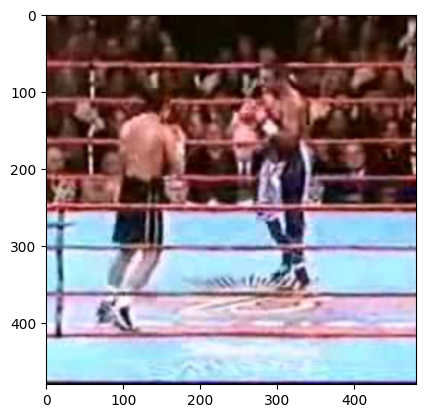

In [26]:
vid0_frame = load_video(val_paths[10])
print(len(vid0_frame))
img_plot_test = vid0_frame[0].permute(1,2,0).numpy() # chuyển về height, width, channel để plot ảnh (224,224,3)
plt.imshow(img_plot_test)

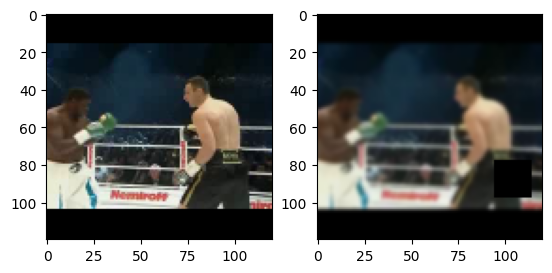

In [27]:
test_augment_path = train_paths[20]
frames_before = load_video(test_augment_path, size=(120,120))
frames_after = augmentation_video(frames_before)

img_after_augment = frames_after[0].permute(1,2,0).numpy()
img_before_augment = frames_before[0].permute(1,2,0).numpy()
fig_aug, ax_aug = plt.subplots(1,2)
ax_aug[0].imshow(img_before_augment)
ax_aug[1].imshow(img_after_augment)

In [ ]:
# train_dataset = VideoDataset(train_paths, all_labels= all_label_train)
# val_dataset = VideoDataset(val_paths, all_labels= all_label_val)
# test_dataset = VideoDataset(test_paths, all_labels= list(df_test['tag']), is_train=False)

In [ ]:
# frames, label = train_dataset.__getitem__(100)
# print(decode_label[label])
# plt.imshow(frames[0].permute(1,2,0).numpy())

#### save & load dataset

In [28]:
import pickle

def save_dataset(dataset, path):
    with open(path, 'wb') as f:
        pickle.dump(dataset, f)

def load_dataset(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
# save_dataset(train_dataset, "./dataset/train_dataset.pickle")
# save_dataset(val_dataset, "./dataset/val_dataset.pickle")
# save_dataset(test_dataset, "./dataset/test_dataset.pickle")

In [29]:
train_dataset = load_dataset("./dataset/train_dataset.pickle")
val_dataset = load_dataset("./dataset/val_dataset.pickle")
test_dataset = load_dataset("./dataset/test_dataset.pickle")

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Model

#### get pretrained

In [31]:
def get_cnn_pretrained(model:str = 'resnet50' or 'resnet101' or 'resnet152'):
    if model=='resnet50':
      CNN_pretrained = torchvision.models.resnet50(pretrained = True)
    elif model=='resnet101':
      CNN_pretrained = torchvision.models.resnet101(pretrained = True)
    else:
      CNN_pretrained = torchvision.models.resnet152(pretrained = True)
    CNN_pretrained = torch.nn.Sequential(*list(CNN_pretrained.children())[:8])
    return CNN_pretrained

In [32]:
sample_frames, sample_label = next(iter(val_dataloader))
print(decode_label[int(sample_label[0])])
sample_frames.shape

PlayingCello


torch.Size([8, 100, 3, 120, 120])

In [33]:
Resnet50 = get_cnn_pretrained('resnet50')
Resnet101 = get_cnn_pretrained('resnet101')
Resnet152 = get_cnn_pretrained('resnet152')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [34]:
output_test = Resnet50(sample_frames[:,1].float())
output_test.shape

torch.Size([8, 2048, 4, 4])

In [35]:
output_test = Resnet101(sample_frames[:,1].float())
output_test.shape

torch.Size([8, 2048, 4, 4])

#### CNN-RNN Model

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [37]:
class LSTM(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(LSTM, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            hidden = torch.zeros((self.batch_size, self.hidden_size))
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.lstm(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res[0])

        return x

In [38]:
class RNN(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(RNN, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.rnn(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res)

        return x

In [39]:
# Thêm patience và delta vào EarlyStopping
class EarlyStopping:
    def __init__(self, path_to_save, delta = 0.01, patience = 3, restore_best_weights=True):
        '''
        delta là tham số kiểm soát độ dao động của loss, loss ở các epoch đầu được phép dao dộng lớn hơn loss ở các epoch về sau
        patience là số lượng epoch mà loss không giảm thì sẽ dừng train
        restore_best_weights là lựa chọn có restore lại weight tốt nhất hay không
        '''
        self.best_val_loss_average = np.inf
        self.best_val_loss = np.inf
        self.path_to_save = path_to_save
        self.early_stop = False
        self.delta = delta
        self.patience = patience
        self.counter = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def __call__(self, current_average_loss_val, current_loss_val,model):
        if current_average_loss_val < self.best_val_loss_average:
            print(f"loss validation average decrease from {self.best_val_loss_average} to {current_average_loss_val}, Saving checkpoint...")
            self.best_val_loss_average = current_average_loss_val
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_loss_val < self.best_val_loss:
            print(f"loss validation decrease from {self.best_val_loss} to {current_loss_val}, Saving checkpoint...")
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_average_loss_val < self.best_val_loss_average + self.delta*self.best_val_loss_average:
            print(f"loss validation average slightly increased from {self.best_val_loss_average} to {current_average_loss_val}, No save! ")
            self.counter += 1
        else:
            self.counter += 1
            print(f"No improvement. Early stopping counter: {self.counter}/{self.patience}")

        # Nếu counter >= patience thì dừng train
        if self.counter >= self.patience:
            print("Early stopping")
            self.early_stop = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
                print("Restore best weights")


### Train

#### trainer

In [40]:
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1, scheduler=None):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_average_train_loss = []
        self.history_average_train_acc = []
        self.history_average_val_loss = []
        self.history_average_val_acc = []
        self.history_train_acc = []
        self.epoch_after_early_stop = 1
        self.early_stop_epoch = 0

        # Thêm scheduler
        self.scheduler = scheduler
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        all_acc_vall_current = []
        last_loss_val = np.inf
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.cpu().detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            all_acc_vall_current.append(acc_val)
            last_loss_val = loss_val
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        loss_val_average = np.average(all_loss_vall_current)
        self.history_average_val_loss.append(loss_val_average)
        self.history_average_val_acc.append(np.average(all_acc_vall_current))
        return loss_val_average, last_loss_val

    def train(self, path_to_save):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = EarlyStopping( path_to_save, delta=0.1)
        index_after_early_stop = 0
        for epoch in range(self.epochs):
            model.train()
            current_loss_train = []
            current_acc_train = []
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            print(optimizer.param_groups[0]['lr'])
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                current_loss_train.append(loss.item())
                current_acc_train.append(acc)
                self.history_train_acc.append(acc)
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            self.history_average_train_loss.append(np.average(current_loss_train))
            self.history_average_train_acc.append(np.average(current_acc_train))
            current_average_loss_val, current_loss_val = self.val(model.eval(), device)

            # Thêm scheduler.step
            if self.scheduler:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(current_average_loss_val)  # Với ReduceLROnPlateau
                    print(f"Learning rate hiện tại: {optimizer.param_groups[0]['lr']}")

            print(f"current_average_loss_val: {current_average_loss_val}")

            if early_stopping.early_stop:
                index_after_early_stop += 1
                print(f"epoch {index_after_early_stop} after early stop")
                if index_after_early_stop == self.epoch_after_early_stop:
                    break
                continue
            early_stopping.delta = 1 * (1/(epoch+1)) # điều chỉnh tham số delta theo epoch
            early_stopping(current_average_loss_val, current_loss_val ,model)
            if early_stopping.early_stop:
                print("\n early stop")
                self.early_stop_epoch = epoch

In [41]:
def get_trainer(model):
    optimizer = torch.optim.AdamW(model.parameters())
    learning_rate = 1e-4
    criterion = nn.CrossEntropyLoss()

    n_epochs = 100

    return Trainer(train_dataloader, val_dataloader, model, optimizer, criterion, n_epochs)

In [42]:
import matplotlib.pyplot as plt

def get_plot(trainer, type, model_name):
    plt.title(model_name)

    if type == 'loss':
        plt.plot(trainer.history_average_train_loss, label='train loss')
        plt.plot(trainer.history_average_val_loss, label='val loss')
    else:
        plt.plot(trainer.history_average_train_acc, label='train acc')
        plt.plot(trainer.history_average_val_acc, label='val acc')
    plt.axvline(trainer.early_stop_epoch - 3, color='r', linestyle='--', label='early stop')
    plt.legend()
    plt.show()

#### config

In [43]:
HIDDEN_SIZE = 512
NUM_CLASSES = 5
BATCH_SIZE = 32

In [44]:
# model = LSTM(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE) # thay đổi batch_size nhớ thay cả ở chỗ này
model_resnet50 = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet101 = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet152 = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)

In [45]:
test_output = model_resnet50(sample_frames.to(device))
test_output

tensor([[ 0.2555, -0.0246,  0.4902, -0.1367, -0.1450],
        [-0.1717,  0.1496,  0.0904, -0.1706, -0.0134],
        [-0.2163,  0.3536,  0.1436,  0.0820, -0.2082],
        [ 0.0170,  0.2879,  0.2471,  0.0791, -0.5685],
        [-0.0527,  0.0445,  0.2048, -0.3651, -0.1482],
        [-0.3963,  0.3754,  0.3285, -0.3528, -0.2716],
        [ 0.2496, -0.0306,  0.4817, -0.1962, -0.1151],
        [ 0.1022,  0.0715,  0.2511,  0.0364, -0.5568]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [46]:
trainer_resnet50 = get_trainer(model_resnet50)
trainer_resnet101 = get_trainer(model_resnet101)
trainer_resnet152 = get_trainer(model_resnet152)

#### ResNet50

In [ ]:
torch.cuda.empty_cache()
trainer_resnet50.train("model50-rnn_checkpoint.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.25 loss_val 1.565132737159729: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


current_average_loss_val: 1.6148841381072998
loss validation average decrease from inf to 1.6148841381072998, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.39 loss_val 1.337088942527771: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.386316180229187
loss validation average decrease from 1.6148841381072998 to 1.386316180229187, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.395 loss_val 1.131974697113037: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.2862613201141357
loss validation average decrease from 1.386316180229187 to 1.2862613201141357, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.37 loss_val 1.3360319137573242: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.5704771280288696
loss validation average slightly increased from 1.2862613201141357 to 1.5704771280288696, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.505 loss_val 1.9571805000305176: 100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


current_average_loss_val: 1.2309174537658691
loss validation average decrease from 1.2862613201141357 to 1.2309174537658691, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.495 loss_val 1.2342138290405273: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.1826831102371216
loss validation average decrease from 1.2309174537658691 to 1.1826831102371216, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.55 loss_val 0.9056355953216553: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


current_average_loss_val: 1.1612584590911865
loss validation average decrease from 1.1826831102371216 to 1.1612584590911865, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.52 loss_val 1.9737615585327148: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.2863554954528809
loss validation average slightly increased from 1.1612584590911865 to 1.2863554954528809, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.43 loss_val 1.7127201557159424: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.2806358337402344
loss validation average slightly increased from 1.1612584590911865 to 1.2806358337402344, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.49 loss_val 1.1950345039367676: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


current_average_loss_val: 1.1929199695587158
loss validation average slightly increased from 1.1612584590911865 to 1.1929199695587158, No save! 
Early stopping
Restore best weights

 early stop


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.575 loss_val 0.7311105728149414: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]

current_average_loss_val: 1.0846556425094604
epoch 1 after early stop


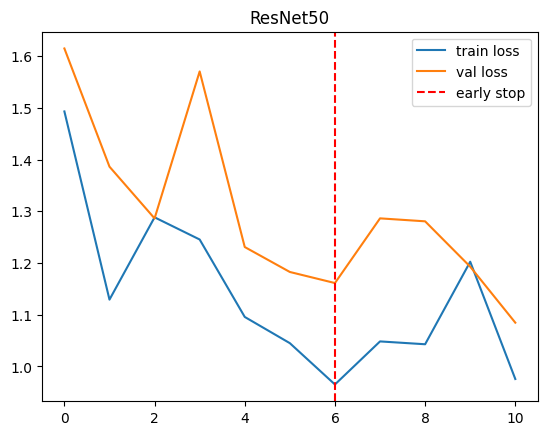

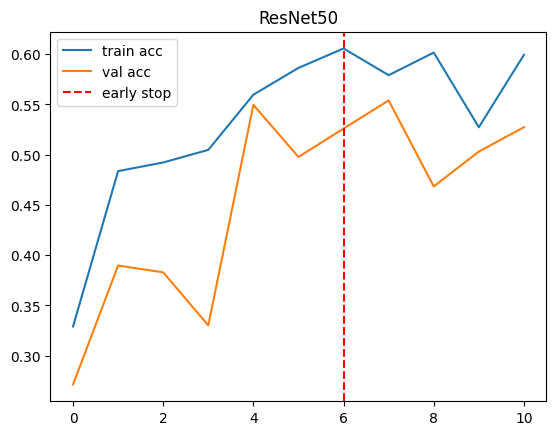

In [ ]:
get_plot(trainer_resnet50, "loss", "ResNet50")
get_plot(trainer_resnet50, "acc", "ResNet50")

#### Resnet101

In [ ]:
torch.cuda.empty_cache()
trainer_resnet101.train("model101-rnn_checkpoint.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.425 loss_val 2.0789308547973633: 100%|██████████| 25/25 [00:45<00:00,  1.82s/it]


current_average_loss_val: 1.6243630647659302
loss validation average decrease from inf to 1.6243630647659302, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.4 loss_val 1.1106234788894653: 100%|██████████| 25/25 [00:44<00:00,  1.80s/it]


current_average_loss_val: 1.6982512474060059
loss validation decrease from 2.0789308547973633 to 1.1106234788894653, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.275 loss_val 1.856410026550293: 100%|██████████| 25/25 [00:44<00:00,  1.80s/it]


current_average_loss_val: 1.7276601791381836
loss validation average slightly increased from 1.6243630647659302 to 1.7276601791381836, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.34 loss_val 0.974185049533844: 100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


current_average_loss_val: 1.332787036895752
loss validation average decrease from 1.6243630647659302 to 1.332787036895752, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.345 loss_val 1.653503656387329: 100%|██████████| 25/25 [00:44<00:00,  1.80s/it]


current_average_loss_val: 1.3827142715454102
loss validation average slightly increased from 1.332787036895752 to 1.3827142715454102, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.4 loss_val 1.3357892036437988: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


current_average_loss_val: 1.547590732574463
loss validation average slightly increased from 1.332787036895752 to 1.547590732574463, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.31 loss_val 1.9031012058258057: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


current_average_loss_val: 2.285719156265259
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.385 loss_val 1.8194468021392822: 100%|██████████| 25/25 [00:44<00:00,  1.79s/it]

current_average_loss_val: 1.7129451036453247
epoch 1 after early stop


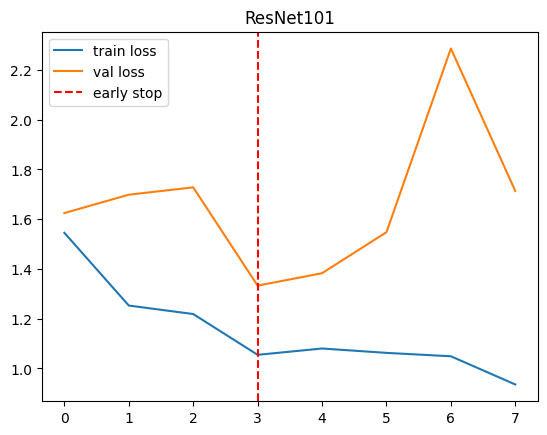

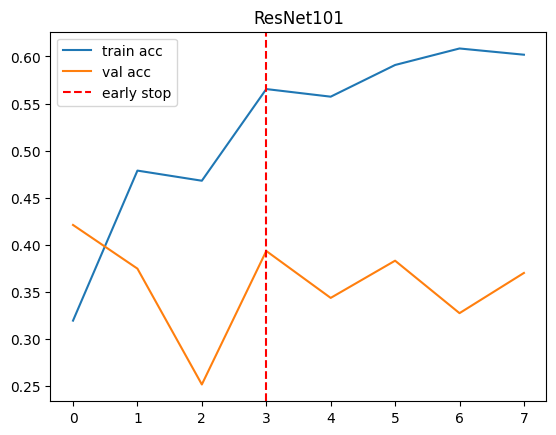

In [ ]:
get_plot(trainer_resnet101, "loss", "ResNet101")
get_plot(trainer_resnet101, "acc", "ResNet101")

#### Resnet152

In [47]:
torch.cuda.empty_cache()
trainer_resnet152.train("model152-rnn_checkpoint.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.435 loss_val 1.4149631261825562: 100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


current_average_loss_val: 1.4213589429855347
loss validation average decrease from inf to 1.4213589429855347, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.44 loss_val 1.2897342443466187: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


current_average_loss_val: 1.4980347156524658
loss validation decrease from 1.4149631261825562 to 1.2897342443466187, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.385 loss_val 1.8957990407943726: 100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


current_average_loss_val: 1.4304624795913696
loss validation average slightly increased from 1.4213589429855347 to 1.4304624795913696, No save! 


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.465 loss_val 1.1883811950683594: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


current_average_loss_val: 1.247298002243042
loss validation average decrease from 1.4213589429855347 to 1.247298002243042, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.66 loss_val 0.8571004867553711: 100%|██████████| 25/25 [01:04<00:00,  2.56s/it]


current_average_loss_val: 1.0789310932159424
loss validation average decrease from 1.247298002243042 to 1.0789310932159424, Saving checkpoint...


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.34 loss_val 1.1306880712509155: 100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


current_average_loss_val: 1.4450260400772095
No improvement. Early stopping counter: 1/3


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.565 loss_val 1.9676318168640137: 100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


current_average_loss_val: 1.630750298500061
No improvement. Early stopping counter: 2/3


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.605 loss_val 0.8655182123184204: 100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


current_average_loss_val: 1.3426234722137451
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/100 [00:00<?, ?it/s]

0.001


Acc_val: 0.54 loss_val 1.2403626441955566: 100%|██████████| 25/25 [01:04<00:00,  2.57s/it]

current_average_loss_val: 1.2166872024536133
epoch 1 after early stop


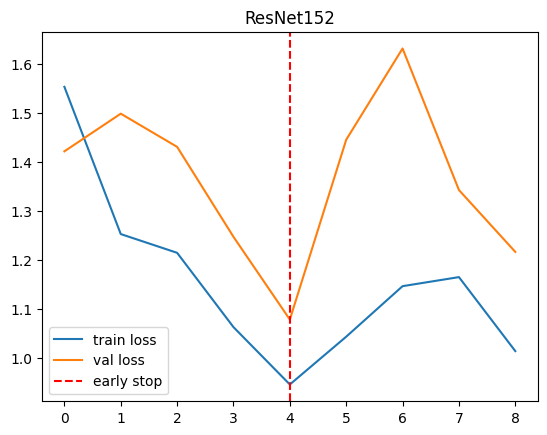

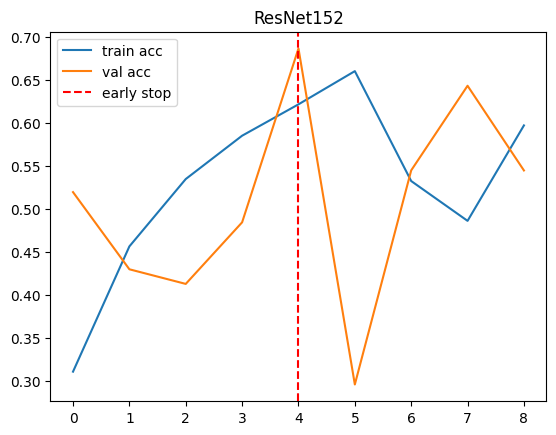

In [48]:
get_plot(trainer_resnet152, "loss", "ResNet152")
get_plot(trainer_resnet152, "acc", "ResNet152")

### Test

In [65]:
class Tester:
    def __init__(self, model, dataloader_test):
        self.dataloader_test = dataloader_test
        self.model = model
    def test(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_test = self.model
        model_test.to(device)
        pbar_test = tqdm(self.dataloader_test)
        total_test = 0
        total_correct_test = 0
        for a, b in pbar_test:
            a = a.to(device)
            b = b.to(device)
            out = model_test(a)
            total_correct_test += (torch.argmax(out, dim=1) == b).sum().item()
            total_test += b.size(0)
            acc_test = total_correct_test/total_test
            pbar_test.set_description(f'Acc_test: {acc_test}')

### Test with resnet50

In [64]:
# model_save = LSTM(CNNPretrained, 512, 5, 8)
model_resnet50_save = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet50_save.load_state_dict(torch.load("./model50-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [67]:
test_resnet50 = Tester(model_resnet50_save, test_dataloader)
test_resnet50.test()

Acc_test: 0.3392857142857143: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]


#### Test with resnet101

In [68]:
# model_save = LSTM(CNNPretrained, 512, 5, 8)
model_resnet101_save = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet101_save.load_state_dict(torch.load("./model101-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [69]:
test_resnet101 = Tester(model_resnet101_save, test_dataloader)
test_resnet101.test()

Acc_test: 0.3169642857142857: 100%|██████████| 28/28 [01:00<00:00,  2.18s/it]


#### Test with resnet152

In [70]:
# model_save = LSTM(CNNPretrained, 512, 5, 8)
model_resnet152_save = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet152_save.load_state_dict(torch.load("./model152-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [71]:
test_resnet152 = Tester(model_resnet152_save, test_dataloader)
test_resnet152.test()

Acc_test: 0.6339285714285714: 100%|██████████| 28/28 [01:11<00:00,  2.56s/it]
